**Name:** ZHAI Qiuyu

**EID:** qiuyuzhai2

# CS5489 - Tutorial 4
## 用MLPS做人脸识别
Face Detection with MLPs

In this tutorial you will train an MLP to detect whether there is a face in a small image patch.

In [24]:
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import matplotlib
# from numpy import *
from sklearn import *
import os
import zipfile
import fnmatch
import skimage.io
import skimage.color
import skimage.transform
from scipy import ndimage
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

Next we will load PyTorch.

In [25]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [26]:
import sys
print("Python:", sys.version, "Torch", torch.__version__)
from typing import List

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0] Torch 2.8.0+cpu


##  导入数据与数据预处理
Next we need to load the images.  Download `faces.zip`, and place it in the same directory as this ipynb file.  **Do not unzip it.** Then run the following cell to load the images.

Next we will convert the list of images into a block (array) of images for easier processing.

In [27]:
# 字典存储数据
imgdata = {'train':[], 'test':[]}
# 字典存储标签
classes = {'train':[], 'test':[]}

# 数据集过大，因此对训练集和测试集进行子采样（减少数据量）

# 将训练集规模缩减为原来的1/ train_subsample（此处为1，即不缩减）
train_subsample = 1

# 训练集中人脸/非人脸的计数
train_counter = [0, 0]
# 测试集中每类样本的最大数量限制
test_maxsample = 472

test_counter = [0, 0]   # 索引0：非人脸，索引1：人脸

# 加载压缩文件
filename = 'faces.zip'
zfile = zipfile.ZipFile(filename, 'r')

# 遍历zip文件中的所有文件名
for name in zfile.namelist():
    # 符合路径格式的png图像文件
    if fnmatch.fnmatch(name, "faces/*/*/*.png"):

        # 解析文件路径，提取数据集类型（训练/测试）和类别（人脸/非人脸）
        (fdir1, fname)  = os.path.split(name)     # 分离出文件名（如fname.png）和上级目录
        (fdir2, fclass) = os.path.split(fdir1)
        (fdir3, fset)   = os.path.split(fdir2)

        # 将类别转换为数字标签：1表示人脸（face），0表示非人脸（nonface）
        myclass = int(fclass == "face")

        # 标记是否加载当前图像
        loadme = False

        # 样本采样和计数
        if fset == 'train':
            # 每train_subsample个样本取1个（此处train_subsample=1，即全部加载）
            if (train_counter[myclass] % train_subsample) == 0:
                loadme = True
            # 更新训练集对应类别的计数
            train_counter[myclass] += 1
        elif fset == 'test':
            # 当测试集对应类别的样本数未超过上限时加载
            if test_counter[myclass] < test_maxsample:
                loadme = True
            # 更新测试集对应类别的计数
            test_counter[myclass] += 1

        # 如果满足加载条件，则读取图像并存储
        if (loadme):
            # 在内存中打开文件
            myfile = zfile.open(name)
            # 读取图像并转换为灰度图（单通道）
            img = skimage.io.imread(myfile, as_gray=True)
            # 关闭文件
            myfile.close()

            # 将图像数据添加到对应数据集（train/test）的列表中
            imgdata[fset].append(img)
            # 将标签添加到对应数据集的列表中
            classes[fset].append(myclass)

# 关闭zip文件
zfile.close()
# 记录图像的尺寸（所有图像尺寸相同，以最后一个加载的图像为例）
imgsize = img.shape

# 打印训练集图像数量
print(len(imgdata['train']))
# 打印测试集图像数量
print(len(imgdata['test']))
# 计算训练集中人脸样本（类别1）的数量（用于后续可能的数据集划分）
trainclass2start = sum(classes['train'])

6977
944


In [28]:
# 将训练集和测试集的标签列表转换为numpy数组（便于后续模型处理）
trainY = np.asarray(classes['train'])
testY  = np.asarray(classes['test'])

# 将图像数据列表（每个元素是单张图像的ndarray）转换为统一的numpy数组
# 并调整形状为（样本数, 高度, 宽度, 通道数），符合卷积神经网络输入格式
trainI = np.asarray(imgdata['train'], dtype=np.float32).reshape((6977,19,19,1))
testI  = np.asarray(imgdata['test'], dtype=np.float32).reshape((944,19,19,1))


# 打乱数据顺序（因为原始数据按类别排列，打乱后更利于模型训练）
np.random.seed(123)  # 设置随机种子，保证结果可复现
inds1 = np.random.permutation(len(trainI)).tolist()  # 生成训练集样本的随机打乱索引
inds2 = np.random.permutation(len(testI)).tolist()   # 生成测试集样本的随机打乱索引

# 按打乱后的索引重新排列标签和图像数据
trainY = trainY[inds1]
testY  = testY[inds2]
trainI = trainI[inds1]
testI = testI[inds2]

print(trainI.shape)
print(testI.shape)

(6977, 19, 19, 1)
(944, 19, 19, 1)


Each image is a 19x19x1 array of pixel values.  The last dimension is the number of channels in the image - in this case the image is grayscale, so there is only 1 channel.  Run the below code to show an example:

(19, 19)


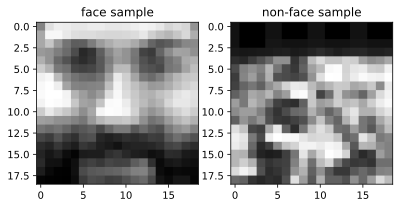

In [29]:
print(img.shape)
plt.subplot(1,2,1)
plt.imshow(np.squeeze(trainI[1]), cmap='gray', interpolation='nearest')
plt.title("face sample")
plt.subplot(1,2,2)
plt.imshow(np.squeeze(trainI[2]), cmap='gray', interpolation='nearest')
plt.title("non-face sample")
plt.show()

Run the below code to show more images!

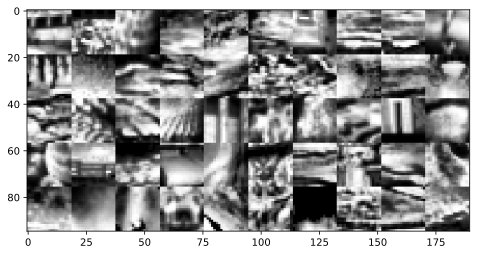

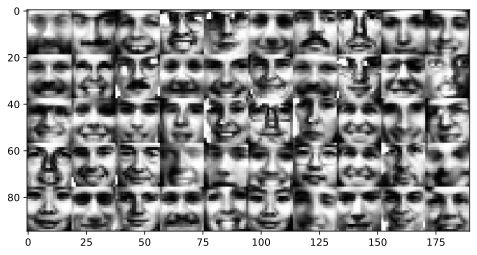

In [30]:
# function to make an image montage
def image_montage(X, imsize=None, maxw=10):
    """X can be a list of images, or a matrix of vectorized images.
      Specify imsize when X is a matrix."""
    tmp = []
    numimgs = len(X)

    # create a list of images (reshape if necessary)
    for i in range(0,numimgs):
        if imsize != None:
            tmp.append(X[i].reshape(imsize))
        else:
            tmp.append(np.squeeze(X[i]))

    # add blanks
    if (numimgs > maxw) and (np.mod(numimgs, maxw) > 0):
        leftover = maxw - np.mod(numimgs, maxw)
        meanimg = 0.5*(X[0].max()+X[0].min())
        for i in range(0,leftover):
            tmp.append(ones(tmp[0].shape)*meanimg)

    # make the montage
    tmp2 = []
    for i in range(0,len(tmp),maxw):
        tmp2.append( np.hstack(tmp[i:i+maxw]) )
    montimg = np.vstack(tmp2)
    return montimg

# show images in a plot
def show_imgs(W_list, nc=10, highlight_green=None, highlight_red=None, titles=None):
    # nc is the number of columns
    nfilter = len(W_list)
    nr = (nfilter - 1) // nc + 1
    for i in range(nr):
        for j in range(nc):
            idx = i * nc + j
            if idx == nfilter:
                break
            plt.subplot(nr, nc, idx + 1)
            cur_W = W_list[idx]
            plt.imshow(cur_W,cmap='gray', interpolation='nearest')
            if titles is not None:
                if isinstance(titles, str):
                    plt.title(titles.format(idx))
                else:
                    plt.title(titles[idx])

            if ((highlight_green is not None) and highlight_green[idx]) or \
               ((highlight_red is not None) and highlight_red[idx]):
                ax = plt.gca()
                if highlight_green[idx]:
                    mycol = '#00FF00'
                else:
                    mycol = 'r'
                for S in ['bottom', 'top', 'right', 'left']:
                    ax.spines[S].set_color(mycol)
                    ax.spines[S].set_lw(2.0)
                ax.xaxis.set_ticks_position('none')
                ax.yaxis.set_ticks_position('none')
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                plt.gca().set_axis_off()

# show a few images
plt.figure(figsize=(9,4))
plt.imshow(image_montage(trainI[trainY==0][0:50]), cmap='gray', interpolation='nearest')
plt.show()

plt.figure(figsize=(9,4))
plt.imshow(image_montage(trainI[trainY==1][0:50]), cmap='gray', interpolation='nearest')
plt.show()

## 把训练集分为训练集与验证集

In [31]:
# generate fixed validation set of 10% of the training set
vtrainI, validI, vtrainY, validY = \
  model_selection.train_test_split(trainI, trainY,
  train_size=0.9, test_size=0.1, random_state=4488)

# make validation data
validsetI = (validI, validY)

print(vtrainI.shape)
print(validI.shape)

(6279, 19, 19, 1)
(698, 19, 19, 1)


### 可视化训练集与验证集的损失变化

In [32]:
#展示损失和精准度的图像
def plot_history2(history):
    fig, ax1 = plt.subplots()
    ax1.plot(history['train_loss'], 'r', label="training loss ({:.6f})".format(history['train_loss'][-1]))
    ax1.plot(history['val_loss'], 'r--', label="validation loss ({:.6f})".format(history['val_loss'][-1]))
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.legend(loc="best", fontsize=9)
    ax1.set_ylabel('loss', color='r')
    ax1.tick_params('y', colors='r')
    if 'train_acc' in history:
        ax2 = ax1.twinx()
        ax2.plot(history['train_acc'], 'b', label="training acc ({:.4f})".format(history['train_acc'][-1]))
        ax2.plot(history['val_acc'], 'b--', label="validation acc ({:.4f})".format(history['val_acc'][-1]))
        ax2.legend(loc="best", fontsize=9)
        ax2.set_ylabel('acc', color='b')
        ax2.tick_params('y', colors='b')

## 自定义神经网络

### 隐藏层，输出层

In [33]:
class MyModel(nn.Module):
    #自己，输入，输出，隐藏层
    def __init__(self, input_size: int, output_size: int, hidden_sizes: List[int]):
        # 初始化父类（nn.Module）
        super().__init__()
        self.input_size, self.output_size, self.hidden_sizes = input_size, output_size, hidden_sizes

        # 隐藏层
        layers = []
        prev_size = input_size

        for curr_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, curr_size))   # 线性变换层（输入，输出）
            layers.append(nn.ReLU())                         # 添加 ReLU 激活函数（逐元素）
            prev_size = curr_size                            # 更新 prev_size，为下一层使用

        # 输出层
        layers.append(nn.Linear(prev_size, output_size))

        # layers.append(nn.Softmax(dim=-1))  # we perform softmax at the outside, not here!
        # 不在模型内部添加 Softmax，因为训练时使用 CrossEntropyLoss 要求传入 raw logits

        # 将所有层打包为一个可调用的顺序容器
        self.network = nn.Sequential(*layers)

    #向前传播
    def forward(self, x):
        t_input = x.view(-1, self.input_size)                # 张量x重塑为二维矩阵（自动计算批次大小，输入大小）
        t_output = self.network(t_input)
        return t_output


### 早停机制

In [34]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0001):
        # patience: 连续多少个 epoch 无明显提升后触发早停
        # min_delta: 把提升视为有效的最小增量（current - best > min_delta）
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0               # 连续无提升的计数器
        self.best_accuracy = 0.0       # 到目前为止观察到的最好验证准确率
        self.early_stop = False        # 是否应该提前停止的标志

    def __call__(self, current_accuracy):
        # 每个 epoch 调用，循环更新验证集准确率
        if current_accuracy - self.best_accuracy > self.min_delta:
            self.best_accuracy = current_accuracy
            self.counter = 0
        else:
            # 没有明显提升：增加计数，超过 patience 则设置早停标志
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

### 训练循环

In [35]:
# define the training loop
def train_model(model, criterion, train_loader, valid_loader, total_epoch: int, patience: int):
    # 早停机制
    early_stopping = EarlyStopping(patience=patience)

    # 记录训练/验证的损失和准确率
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    # 遍历每个 epoch
    for epoch in range(total_epoch):
        # 切换到训练模式（启用 dropout，使用 batch stats）
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # 遍历训练数据的每个 mini-batch
        for inputs, labels in train_loader:
            optimizer.zero_grad()                # 1. 清零累计梯度
            outputs = model(inputs)              # 2. 前向传播，得到模型输出
            loss = criterion(outputs, labels)    # 3. 计算损失
            loss.backward()                      # 4. 反向传播，计算梯度
            optimizer.step()                     # 5. 优化器更新参数

            # 记录本 batch 的损失和正确数（不计算梯度以节省内存）
            with torch.no_grad():
                running_loss += loss.item()     # 累加损失标量
                predicted = torch.argmax(outputs, -1)  # 取概率/logits 中概率最高的类
                total += labels.size(0)         # 累加样本数
                correct += (predicted == labels).sum().item()  # 累加正确预测数

        # 计算并保存本次 epoch 的训练损失和准确率
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # 切换到评估模式（禁用 dropout，使用 running stats）
        val_loss = 0.0
        model.eval()  #
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                predicted = torch.argmax(outputs, -1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # 计算并保存本次epoch的验证损失和准确率
        val_loss = val_loss / len(valid_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # 打印本 epoch 的训练/验证结果
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        # 调用早停对象：当验证准确率在 patience 个 epoch 内没有提升超过 min_delta 时停止训练
        if early_stopping(val_acc):
            print("Early stopping triggered")
            break
    # 返回训练历史，用于绘图或分析
    return {'train_loss': train_losses, 'train_acc': train_accs, 'val_loss': val_losses, 'val_acc': val_accs}

### 输入数据格式转变器

In [36]:
# get dataset and dataloader
def get_dataloader(t_input, t_output, batch_size=32, shuffle=False):

    # 变成torch的tensor
    t_input, t_output = torch.as_tensor(t_input), torch.as_tensor(t_output,dtype=torch.long)
    #这里我添加了指定类型，课件那里不会报错是因为其标签原始数据类型（uint8）与torch.as_tensor的自动映射逻辑 “恰好匹配” 了CrossEntropyLoss的需求
    #而这次的标签数据类型为torch.int，torch.as_tensor转换后为torch.int32（torch.int），不符合CrossEntropyLoss要求；

    # 使用 TensorDataset 将输入与标签配对，方便 DataLoader 按 batch 取出
    dataset = TensorDataset(t_input, t_output)

    # DataLoader: batch_size 指定每个 mini-batch 的样本数，shuffle 控制是否随机打乱数据
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return loader

## 逻辑回归模型

Epoch 1: Train Loss: 0.1351, Train Acc: 0.9451, Val Loss: 0.1050, Val Acc: 0.9642
Epoch 2: Train Loss: 0.0711, Train Acc: 0.9753, Val Loss: 0.0696, Val Acc: 0.9699
Epoch 3: Train Loss: 0.0636, Train Acc: 0.9766, Val Loss: 0.0628, Val Acc: 0.9728
Epoch 4: Train Loss: 0.0588, Train Acc: 0.9777, Val Loss: 0.0670, Val Acc: 0.9785
Epoch 5: Train Loss: 0.0561, Train Acc: 0.9790, Val Loss: 0.0585, Val Acc: 0.9785
Epoch 6: Train Loss: 0.0530, Train Acc: 0.9807, Val Loss: 0.0603, Val Acc: 0.9742
Epoch 7: Train Loss: 0.0508, Train Acc: 0.9815, Val Loss: 0.0657, Val Acc: 0.9670
Epoch 8: Train Loss: 0.0498, Train Acc: 0.9806, Val Loss: 0.0709, Val Acc: 0.9771
Epoch 9: Train Loss: 0.0472, Train Acc: 0.9841, Val Loss: 0.0735, Val Acc: 0.9756
Epoch 10: Train Loss: 0.0467, Train Acc: 0.9828, Val Loss: 0.0601, Val Acc: 0.9785
Epoch 11: Train Loss: 0.0443, Train Acc: 0.9842, Val Loss: 0.0641, Val Acc: 0.9756
Epoch 12: Train Loss: 0.0441, Train Acc: 0.9842, Val Loss: 0.0545, Val Acc: 0.9742
Epoch 13: Tra

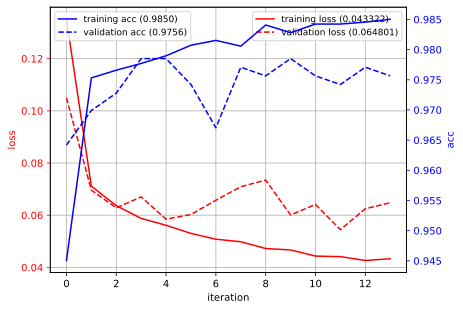

In [37]:
# initialize random seed
torch.manual_seed(4487)
np.random.seed(4487)
random.seed(4487)

# trying a simple logistic regression
model = MyModel(input_size=19*19, output_size=2, hidden_sizes=[])  # one layer model
criterion = nn.CrossEntropyLoss()  # loss function
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9, nesterov=True)  # optimizer
train_loader = get_dataloader(vtrainI, vtrainY, batch_size=50, shuffle=True)  # data loaders
val_loader = get_dataloader(validI, validY, batch_size=50)

# train the model
history = train_model(model, criterion, train_loader, val_loader, total_epoch=100, patience=10)
plot_history2(history)

# test
predY = model(torch.as_tensor(testI)).argmax(-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

## Detection using MLP

Train an MLP to classify an image patch as face or not face.  Use  `vtrainI` and `vtrainY` as the training set and `validsetI` as the validation set.  You can try different architectures, and adjust values of the learning rates, number of iterations, early stopping to get a good result.  Use a large batch size (e.g., 50) to speed up the training time.  Remember to monitor the training process.

## MLP

In [38]:
### INSERT YOUR CODE HERE

### 隐藏层50，20

Epoch 1: Train Loss: 0.3177, Train Acc: 0.8683, Val Loss: 0.1272, Val Acc: 0.9628
Epoch 2: Train Loss: 0.0943, Train Acc: 0.9645, Val Loss: 0.0764, Val Acc: 0.9699
Epoch 3: Train Loss: 0.0741, Train Acc: 0.9739, Val Loss: 0.1475, Val Acc: 0.9670
Epoch 4: Train Loss: 0.0682, Train Acc: 0.9756, Val Loss: 0.0687, Val Acc: 0.9756
Epoch 5: Train Loss: 0.0606, Train Acc: 0.9799, Val Loss: 0.0981, Val Acc: 0.9742
Epoch 6: Train Loss: 0.0532, Train Acc: 0.9791, Val Loss: 0.0749, Val Acc: 0.9771
Epoch 7: Train Loss: 0.0501, Train Acc: 0.9846, Val Loss: 0.0715, Val Acc: 0.9756
Epoch 8: Train Loss: 0.0477, Train Acc: 0.9836, Val Loss: 0.0776, Val Acc: 0.9771
Epoch 9: Train Loss: 0.0508, Train Acc: 0.9823, Val Loss: 0.0544, Val Acc: 0.9814
Epoch 10: Train Loss: 0.0393, Train Acc: 0.9868, Val Loss: 0.0559, Val Acc: 0.9756
Epoch 11: Train Loss: 0.0397, Train Acc: 0.9866, Val Loss: 0.0581, Val Acc: 0.9828
Epoch 12: Train Loss: 0.0321, Train Acc: 0.9881, Val Loss: 0.0416, Val Acc: 0.9799
Epoch 13: Tra

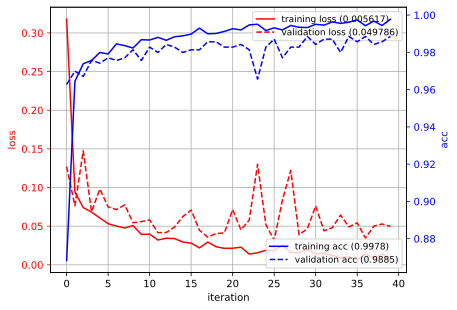

In [39]:
torch.manual_seed(4487)
np.random.seed(4487)
random.seed(4487)

# MLP
model = MyModel(input_size=19*19, output_size=2, hidden_sizes=[50, 20])

# 损失函数
criterion = nn.CrossEntropyLoss()

# 优化器
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True)

# 老师要求的更大 batch size
train_loader = get_dataloader(vtrainI, vtrainY, batch_size=50, shuffle=True)
val_loader = get_dataloader(validI, validY, batch_size=50)

# 带有早停的训练
history = train_model(model, criterion, train_loader, val_loader, total_epoch=100, patience=10)

# 画图
plot_history2(history)

# 在测试数据上评估模型
with torch.no_grad():
    predY = model(torch.as_tensor(testI)).argmax(-1)
    acc = metrics.accuracy_score(testY, predY)
    print("Test accuracy:", acc)

### 隐藏层100，50，20

Epoch 1: Train Loss: 0.2153, Train Acc: 0.8943, Val Loss: 0.0801, Val Acc: 0.9713
Epoch 2: Train Loss: 0.0731, Train Acc: 0.9734, Val Loss: 0.0528, Val Acc: 0.9785
Epoch 3: Train Loss: 0.0528, Train Acc: 0.9793, Val Loss: 0.0333, Val Acc: 0.9828
Epoch 4: Train Loss: 0.0379, Train Acc: 0.9874, Val Loss: 0.0309, Val Acc: 0.9885
Epoch 5: Train Loss: 0.0426, Train Acc: 0.9849, Val Loss: 0.0403, Val Acc: 0.9842
Epoch 6: Train Loss: 0.0337, Train Acc: 0.9879, Val Loss: 0.0339, Val Acc: 0.9857
Epoch 7: Train Loss: 0.0298, Train Acc: 0.9892, Val Loss: 0.0430, Val Acc: 0.9842
Epoch 8: Train Loss: 0.0221, Train Acc: 0.9911, Val Loss: 0.0201, Val Acc: 0.9914
Epoch 9: Train Loss: 0.0261, Train Acc: 0.9895, Val Loss: 0.0558, Val Acc: 0.9842
Epoch 10: Train Loss: 0.0160, Train Acc: 0.9941, Val Loss: 0.0556, Val Acc: 0.9828
Epoch 11: Train Loss: 0.0234, Train Acc: 0.9925, Val Loss: 0.2132, Val Acc: 0.9183
Epoch 12: Train Loss: 0.0201, Train Acc: 0.9928, Val Loss: 0.0207, Val Acc: 0.9900
Epoch 13: Tra

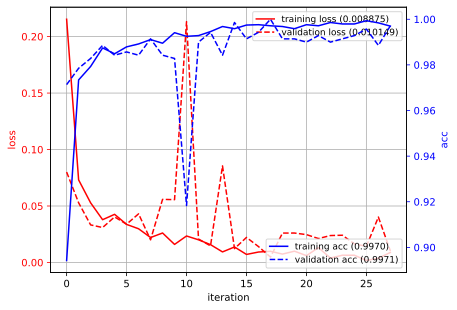

In [40]:
torch.manual_seed(4487)
np.random.seed(4487)
random.seed(4487)

# MLP
model = MyModel(input_size=19*19, output_size=2, hidden_sizes=[100, 50, 20])

# 损失函数
criterion = nn.CrossEntropyLoss()

# 优化器
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True)

# 老师要求的更大 batch size
train_loader = get_dataloader(vtrainI, vtrainY, batch_size=50, shuffle=True)
val_loader = get_dataloader(validI, validY, batch_size=50)

# 带有早停的训练
history = train_model(model, criterion, train_loader, val_loader, total_epoch=100, patience=10)

# 画图
plot_history2(history)

# 在测试数据上评估模型
with torch.no_grad():
    predY = model(torch.as_tensor(testI)).argmax(-1)
    acc = metrics.accuracy_score(testY, predY)
    print("Test accuracy:", acc)

### 隐藏层100，100，50

Epoch 1: Train Loss: 0.6701, Train Acc: 0.6843, Val Loss: 0.6719, Val Acc: 0.6519
Epoch 2: Train Loss: 0.6481, Train Acc: 0.6519, Val Loss: 0.6483, Val Acc: 0.6519
Epoch 3: Train Loss: 0.6481, Train Acc: 0.6519, Val Loss: 0.6474, Val Acc: 0.6519
Epoch 4: Train Loss: 0.6487, Train Acc: 0.6519, Val Loss: 0.6467, Val Acc: 0.6519
Epoch 5: Train Loss: 0.6488, Train Acc: 0.6519, Val Loss: 0.6464, Val Acc: 0.6519
Epoch 6: Train Loss: 0.6486, Train Acc: 0.6519, Val Loss: 0.6469, Val Acc: 0.6519
Epoch 7: Train Loss: 0.6487, Train Acc: 0.6519, Val Loss: 0.6463, Val Acc: 0.6519
Epoch 8: Train Loss: 0.6483, Train Acc: 0.6519, Val Loss: 0.6471, Val Acc: 0.6519
Epoch 9: Train Loss: 0.6475, Train Acc: 0.6519, Val Loss: 0.6516, Val Acc: 0.6519
Epoch 10: Train Loss: 0.6484, Train Acc: 0.6519, Val Loss: 0.6467, Val Acc: 0.6519
Epoch 11: Train Loss: 0.6473, Train Acc: 0.6519, Val Loss: 0.6503, Val Acc: 0.6519
Early stopping triggered
Test accuracy: 0.5


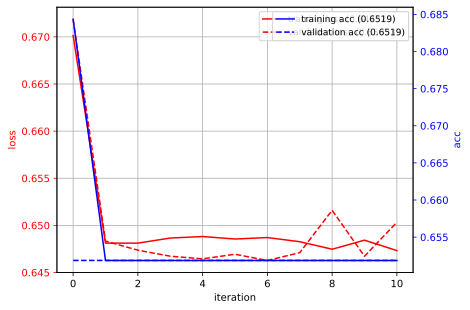

In [41]:
torch.manual_seed(4487)
np.random.seed(4487)
random.seed(4487)

# MLP
model = MyModel(input_size=19*19, output_size=2, hidden_sizes=[100,100,50])

# 损失函数
criterion = nn.CrossEntropyLoss()

# 优化器
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True)

# 老师要求的更大 batch size
train_loader = get_dataloader(vtrainI, vtrainY, batch_size=50, shuffle=True)
val_loader = get_dataloader(validI, validY, batch_size=50)

# 带有早停的训练
history = train_model(model, criterion, train_loader, val_loader, total_epoch=100, patience=10)

# 画图
plot_history2(history)

# 在测试数据上评估模型
with torch.no_grad():
    predY = model(torch.as_tensor(testI)).argmax(-1)
    acc = metrics.accuracy_score(testY, predY)
    print("Test accuracy:", acc)

_How does the MLP compare to the linear and non-linear classifiers that you tried in Tutorial 4?_
- **INSERT YOUR ANSWER HERE**

Compared to linear classifiers, MLPs can learn more complex decision boundaries and have greater expressive power, but they require more data, are more prone to overfitting, and take longer to train.

Compared to traditional non-linear classifiers, MLPs can be trained end-to-end and automatically learn features, but they require more hyperparameter tuning and greater computational resources.


MLP相比线性分类器可以学习更复杂的决策边界，表达能力更强,但是需要更多数据，而且容易过拟合，训练时间更长

MLP相比传统非线性分类器可以端到端学习，自动特征提取，但是需要更多调参，计算资源需求更高

## 数据增强

Data Augmentation

The reason why we are not getting good accuracy with MLP is because there is not a lot of data, only ~7000 training images, compared to the number of parameters in the MLP.

Augmenting the training data with permutations  (e.g., scaling, rotating, skewing, flipping) is a good way to create more "data" for training the network.

通过排列变换（例如缩放、旋转、倾斜、翻转）增强训练数据，是为网络训练创造更多“数据”的有效方法。

This can prevent the MLP from overfitting, and improve its generalization.

We can also add per-pixel noise or transformations. We define a few functions for adding per-pixel noise.  The following functions will add Gaussian pixel noise, add corruption noise (setting some input pixels to 0), scale and shift pixel values (changing contrast and brightness).

我们还可以添加逐像素噪声或变换。我们定义了若干用于添加逐像素噪声的函数。以下函数将添加高斯像素噪声、添加损坏噪声（将部分输入像素设为0）、缩放和偏移像素值（改变对比度和亮度）。

In [42]:
import torchvision.transforms as transforms
#PyTorch 生态中用于图像数据预处理与增强的核心工具导入语句，torchvision 库中专处理图像变换的模块

# 高斯噪声添加
class AddGaussNoise:
    def __init__(self, sigma2=0.05):
        # 初始化高斯噪声的方差（sigma²）
        self.sigma2 = sigma2

    def __call__(self, x):
        # 生成与输入图像x形状相同的高斯噪声（均值0，标准差sqrt(sigma2)）
        noise = torch.randn_like(x) * np.sqrt(self.sigma2)
        # 给图像添加噪声后，将像素值裁剪到[0.0, 1.0]范围（避免超出合理范围）
        return torch.clamp(x + noise, 0.0, 1.0)

# 随机损坏噪声添加（类似随机遮挡）
class AddCorruptNoise:
    def __init__(self, p=0.1):
        # 初始化损坏概率p为0.1：每个像素有p的概率被置为0（遮挡）
        self.p = p

    def __call__(self, x):
        # 生成与x形状相同的掩码：1的概率为(1-p)，0的概率为p（用伯努利分布采样）
        mask = torch.bernoulli(torch.ones_like(x) * (1-self.p))
        # 图像与掩码相乘：掩码为0的位置像素被置为0（模拟遮挡噪声）
        return x * mask

# 缩放与偏移变换（模拟亮度/对比度变化）
class AddScaleShift:
    def __init__(self, sigma2=0.1, alpha2=0.2):
        # 初始化缩放系数的方差（sigma²）和偏移量的方差（alpha²）
        self.sigma2 = sigma2
        self.alpha2 = alpha2

    def __call__(self, x):
        # 随机生成缩放系数a（围绕1.0的正态分布）
        a = torch.normal(1.0, np.sqrt(self.sigma2), size=(1,))
        # 随机生成偏移量b（围绕0.0的正态分布）
        b = torch.normal(0.0, np.sqrt(self.alpha2), size=(1,))
        # 对图像进行缩放（a*x）和偏移（+b），结果裁剪到[0.0, 1.0]
        return torch.clamp(a * x + b, 0.0, 1.0)

# 组合噪声函数（当前仅使用高斯噪声，可扩展）
class AddNoise:
    def __init__(self):
        # 初始化高斯噪声实例
        self.gauss = AddGaussNoise()

    def __call__(self, x):
        # 对输入图像应用高斯噪声
        return self.gauss(x)

# 数据增强流水线（按顺序应用多个变换）
augmentation = transforms.Compose([
    # 随机仿射变换：包含旋转、平移、剪切、缩放
    transforms.RandomAffine(
        degrees=10,  # 随机旋转角度范围（-10°到10°）
        translate=(0.05, 0.05),  # 随机平移范围（宽和高方向各0-5%）
        shear=5,  # 随机剪切角度（-5°到5°）
        scale=(0.95, 1.05)  # 随机缩放范围（0.95倍到1.05倍）
    ),
    # 随机水平翻转：50%概率翻转图像
    transforms.RandomHorizontalFlip(p=0.5),
    # 添加高斯噪声
    AddNoise(),
])

Next we can show some examples of augmented images. Run the code below to see different random augmentations.

torch.Size([19, 19, 1])


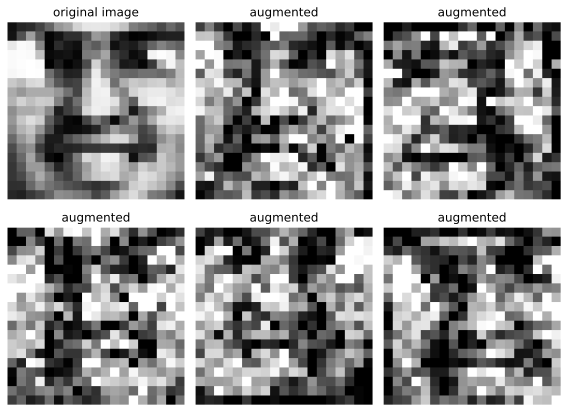

In [43]:
def show_imgs(imgs, nc=3, titles=None):
    n = len(imgs)
    nr = (n + nc - 1) // nc
    plt.figure(figsize=(8, 6))
    for i in range(n):
        plt.subplot(nr, nc, i+1)
        plt.imshow(imgs[i], cmap='gray')
        plt.axis('off')
        if titles and i < len(titles):
            plt.title(titles[i])
    plt.tight_layout()
    plt.show()

img = trainI[9]  # pick one
img_tensor = torch.FloatTensor(img)
print(img_tensor.shape)

cnt = 0
imgs = [img]
for _ in range(5):
    aug_img = augmentation(img_tensor.permute(2, 0, 1))
    imgs.append(aug_img.permute(1, 2, 0)[..., 0].numpy())
    cnt += 1
    if cnt >= 5:
        break

# show the results
titles = ['original image', 'augmented', 'augmented', 'augmented', 'augmented', 'augmented']
show_imgs(imgs, nc=3, titles=titles)

The augmented images look similar to the original image, but contain small differences that the network can use to learn more about the class.

Now let's try training logistic regression with data augmentation. Instead sending the original X,Y data, we now transform it first.

## 带有数据增强的数据集类和输入数据格式转变器

In [44]:
# 定义带数据增强的数据集类（继承自PyTorch的TensorDataset）
class AugmentedTensorDataset(TensorDataset):
    def __init__(self, *tensors, transform=None):
        # 传入所有张量（通常是图像和标签）
        super().__init__(*tensors)
        # 保存数据增强变换
        self.transform = transform

    def __getitem__(self, index):
        # 获取图像数据
        img = self.tensors[0][index]
        # 获取标签
        label = self.tensors[1][index]

        # 如果指定了数据增强变换，则对图像应用变换
        if self.transform:
            # 1. 先将图像维度从 (H, W, C) 转换为 (C, H, W)
            # 2. 应用增强变换
            # 3. 再将维度转换回 (H, W, C)
            img = self.transform(img.permute(2, 0, 1)).permute(1, 2, 0)

        return img, label

# 创建带数据增强的DataLoader
def get_aug_dataloader(t_input, t_output, batch_size=50, shuffle=False, transform=None):

    t_input, t_output = torch.as_tensor(t_input), torch.as_tensor(t_output)#同之前

    # 实例化带增强的数据集，传入图像、标签和增强变换
    dataset = AugmentedTensorDataset(t_input, t_output, transform=transform)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)#同之前
    return loader

Epoch 1: Train Loss: 0.4387, Train Acc: 0.8595, Val Loss: 0.1439, Val Acc: 0.9456
Epoch 2: Train Loss: 0.3320, Train Acc: 0.8772, Val Loss: 0.1247, Val Acc: 0.9542
Epoch 3: Train Loss: 0.3286, Train Acc: 0.8823, Val Loss: 0.1161, Val Acc: 0.9570
Epoch 4: Train Loss: 0.3270, Train Acc: 0.8825, Val Loss: 0.1206, Val Acc: 0.9470
Epoch 5: Train Loss: 0.3418, Train Acc: 0.8780, Val Loss: 0.1479, Val Acc: 0.9470
Epoch 6: Train Loss: 0.3238, Train Acc: 0.8739, Val Loss: 0.1108, Val Acc: 0.9527
Epoch 7: Train Loss: 0.3054, Train Acc: 0.8868, Val Loss: 0.2533, Val Acc: 0.9097
Epoch 8: Train Loss: 0.3031, Train Acc: 0.8858, Val Loss: 0.1168, Val Acc: 0.9556
Epoch 9: Train Loss: 0.3467, Train Acc: 0.8793, Val Loss: 0.1238, Val Acc: 0.9456
Epoch 10: Train Loss: 0.3034, Train Acc: 0.8818, Val Loss: 0.2422, Val Acc: 0.9140
Epoch 11: Train Loss: 0.3238, Train Acc: 0.8783, Val Loss: 0.1255, Val Acc: 0.9499
Epoch 12: Train Loss: 0.3197, Train Acc: 0.8833, Val Loss: 0.1655, Val Acc: 0.9355
Epoch 13: Tra

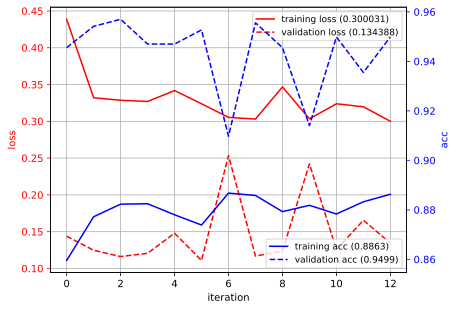

In [45]:
# initialize random seed
torch.manual_seed(4487)
np.random.seed(4487)
random.seed(4487)

# trying a simple logistic regression
model = MyModel(input_size=19*19, output_size=2, hidden_sizes=[])  # one layer model
criterion = nn.CrossEntropyLoss()  # loss function
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True)  # optimizer
train_loader = get_aug_dataloader(vtrainI, vtrainY, batch_size=50, shuffle=True, transform=augmentation)  # data loaders
val_loader = get_dataloader(validI, validY, batch_size=50)
# train the model
history = train_model(model, criterion, train_loader, val_loader, total_epoch=100, patience=10)

# test
plot_history2(history)
predY = model(torch.as_tensor(testI)).argmax(-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

Using data augmentation, the test accuracy improves!

Now train your best MLP from the previous section using data augmentation.
Try different per-pixel noise levels, and different options and combinations of them.  Hopefully you should be able to improve the accuracy!

In [46]:
### INSERT YOUR CODE HERE ###

In [47]:
# 定义不同强度的噪声参数（覆盖弱/中/强）
gauss_levels = [0.01, 0.05, 0.1]    # 高斯噪声方差（越大噪声越强）
corrupt_levels = [0.02, 0.1, 0.2]   # 随机损坏概率
# 缩放与偏移参数（sigma², alpha²）
scale_shift_params = [
    (0.02, 0.05),
    (0.05, 0.1),   # 中强度
    (0.1, 0.2)     # 高强度
]

# 数据增强流水线字典
augmentations = {
    # 对照组：无噪声，仅基础几何变换
    'baseline_affine': transforms.Compose([
        transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
        transforms.RandomHorizontalFlip(p=0.5),
    ]),
}

# 1. 单一高斯噪声（不同强度）
gauss_augs = {
    f'gauss_{s}': transforms.Compose([
        transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
        transforms.RandomHorizontalFlip(p=0.5),
        AddGaussNoise(sigma2=s)
    ]) for s in gauss_levels
}
augmentations.update(gauss_augs)  # 合并到主字典

# 2. 单一损坏噪声（不同强度）
corrupt_augs = {
    f'corrupt_{p}': transforms.Compose([
        transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
        transforms.RandomHorizontalFlip(p=0.5),
        AddCorruptNoise(p=p)
    ]) for p in corrupt_levels
}
augmentations.update(corrupt_augs)  # 合并到主字典

# 3. 单一缩放偏移（不同强度）
scale_shift_augs = {
    f'scale_shift_{s}_{a}': transforms.Compose([
        transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
        transforms.RandomHorizontalFlip(p=0.5),
        AddScaleShift(sigma2=s, alpha2=a)
    ]) for s, a in scale_shift_params
}
augmentations.update(scale_shift_augs)  # 合并到主字典

# 4. 添加噪声组合策略
augmentations.update({
    # 噪声组合：高斯 + 遮挡（中等强度）
    'gauss_corrupt': transforms.Compose([
        transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
        transforms.RandomHorizontalFlip(p=0.5),
        AddGaussNoise(sigma2=0.05),
        AddCorruptNoise(p=0.1),
    ]),
    # 噪声组合：高斯 + 缩放偏移（中等强度）
    'gauss_scale': transforms.Compose([
        transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
        transforms.RandomHorizontalFlip(p=0.5),
        AddGaussNoise(sigma2=0.05),
        AddScaleShift(sigma2=0.05, alpha2=0.1),
    ]),
    # 强增强组合：所有噪声 + 更强几何变换
    'enhanced_full': transforms.Compose([
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), shear=10, scale=(0.9, 1.1)),
        transforms.RandomHorizontalFlip(p=0.5),
        AddGaussNoise(sigma2=0.05),
        AddCorruptNoise(p=0.1),
        AddScaleShift(sigma2=0.05, alpha2=0.1),
    ]),
})

In [48]:
# 使用最佳MLP架构测试所有增强策略
best_accuracy = 0
best_augmentation = None
results = {}

for aug_name, aug_transform in augmentations.items():
    print(f"\n=== 测试增强策略: {aug_name} ===")

    # 创建模型
    model = MyModel(input_size=19*19, output_size=2, hidden_sizes=[100, 50, 20])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True)

    # 创建数据加载器
    train_loader = get_aug_dataloader(vtrainI, vtrainY, batch_size=50, shuffle=True, transform=aug_transform)
    val_loader = get_dataloader(validI, validY, batch_size=50)

    # 训练和测试
    history = train_model(model, criterion, train_loader, val_loader, total_epoch=100, patience=10)

    with torch.no_grad():
        predY = model(torch.as_tensor(testI)).argmax(-1)
        acc = metrics.accuracy_score(testY, predY)
        results[aug_name] = acc
        print(f"测试准确率: {acc:.4f}")

        if acc > best_accuracy:
            best_accuracy = acc
            best_augmentation = aug_name

print(f"\n=== 结果汇总 ===")
print(f"最佳增强策略: {best_augmentation}")
print(f"最佳准确率: {best_accuracy:.4f}")


=== 测试增强策略: baseline_affine ===
Epoch 1: Train Loss: 0.6402, Train Acc: 0.6692, Val Loss: 0.6471, Val Acc: 0.6519
Epoch 2: Train Loss: 0.6477, Train Acc: 0.6519, Val Loss: 0.6464, Val Acc: 0.6519
Epoch 3: Train Loss: 0.6432, Train Acc: 0.6571, Val Loss: 0.5630, Val Acc: 0.6361
Epoch 4: Train Loss: 0.3151, Train Acc: 0.8595, Val Loss: 0.1722, Val Acc: 0.9384
Epoch 5: Train Loss: 0.2389, Train Acc: 0.9056, Val Loss: 0.1430, Val Acc: 0.9384
Epoch 6: Train Loss: 0.2128, Train Acc: 0.9170, Val Loss: 0.1423, Val Acc: 0.9427
Epoch 7: Train Loss: 0.2117, Train Acc: 0.9180, Val Loss: 0.1124, Val Acc: 0.9570
Epoch 8: Train Loss: 0.2163, Train Acc: 0.9178, Val Loss: 0.1221, Val Acc: 0.9527
Epoch 9: Train Loss: 0.2016, Train Acc: 0.9220, Val Loss: 0.1171, Val Acc: 0.9556
Epoch 10: Train Loss: 0.1793, Train Acc: 0.9279, Val Loss: 0.1093, Val Acc: 0.9527
Epoch 11: Train Loss: 0.1700, Train Acc: 0.9336, Val Loss: 0.1056, Val Acc: 0.9613
Epoch 12: Train Loss: 0.1671, Train Acc: 0.9349, Val Loss: 0.12

_Which type of augmentation improves the accuracy the most?  Why?_

- **INSERT YOUR ANSWER HERE**

According to the test results, among various data augmentation strategies, Gaussian noise augmentation (gauss_0.1) achieved the highest accuracy of 86.76%. This strategy exhibited relatively stable convergence during training. Although its training loss and accuracy fluctuated more than other strategies, it ultimately achieved the best performance on the validation set. This indicates that moderate noise interference (standard deviation of 0.1) may effectively mitigate overfitting by enhancing the model's robustness to input variations, thereby improving generalization capabilities. Other augmentation strategies, such as the baseline affine transformation (baseline_affine) and lower-intensity versions of Gaussian noise (gauss_0.01, gauss_0.05), failed to achieve comparable results. This underscores that the judicious selection of noise intensity is crucial for performance enhancement.


# Test image
Now lets try your face detector on a real image.  Download the "nasa-small.png" image and put it in the same directory as your ipynb file.  The below code will load the image, crop out image patches and then extract features. (this may take a few minutes)

In [49]:
fname = "nasa-small.png"

(210, 480)


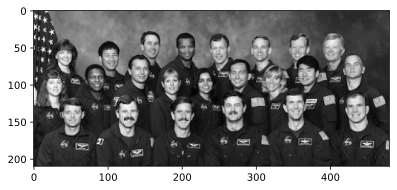

In [50]:
# fname：图像文件路径（如'example.png'）
# as_gray=True：将图像读取为单通道灰度图（而非彩色RGB图）
testimg = skimage.io.imread(fname, as_gray=True)

# 打印图像的形状（维度信息）
print(testimg.shape)

# 使用matplotlib显示灰度图像
plt.imshow(testimg, cmap='gray')

In [51]:
# 滑动窗口的步长（每次窗口移动的像素数）
step = 4

# testimg：输入的灰度图像（形状为(H, W)）
# (19,19)：窗口大小（每个图像块的高度和宽度均为19像素）
# step=step：窗口每次移动4个像素
patches = skimage.util.view_as_windows(testimg, (19,19), step=step)

# 获取提取的图像块的形状（维度信息）
psize = patches.shape

# 转换后形状为 (行×列, 19, 19, 1)
patches2 = patches.reshape((psize[0]*psize[1], psize[2], psize[3], 1))
# 打印转换后图像块的形状，确认数量和尺寸是否正确
print(patches2.shape)

# 当前未执行直方图均衡化，直接将原始图像块赋值给newI
newI = patches2

# 直方图均衡化处理
newI2 = np.empty(patches2.shape, dtype=np.float32)
for i in range(patches2.shape[0]):
   newI2[i,:,:,0] = skimage.exposure.equalize_hist(patches2[i,:,:,0])

(5568, 19, 19, 1)


Now predict using your classifier.  The extracted images are in `newI`.

In [52]:
### YOUR CODE HERE

In [63]:
# 对测试图像进行预测
with torch.no_grad():
    prednewY2 = best_model(torch.as_tensor(newI2, dtype=torch.float32)).argmax(-1).numpy()

print("预测完成，预测结果形状:", prednewY2.shape)
print("预测结果统计:", np.bincount(prednewY2))

预测完成，预测结果形状: (5568,)
预测结果统计: [5514   54]


In [67]:
# 使用最佳增强策略训练最终模型
torch.manual_seed(4487)
np.random.seed(4487)
random.seed(4487)

# 创建最佳模型
best_model = MyModel(input_size=19*19, output_size=2, hidden_sizes=[100, 50, 20])
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(best_model.parameters(), lr=0.1, momentum=0.9, nesterov=True)

# 使用最佳增强策略训练
best_aug_transform = augmentations['gauss_0.1']
train_loader = get_aug_dataloader(vtrainI, vtrainY, batch_size=50, shuffle=True, transform=best_aug_transform)
val_loader = get_dataloader(validI, validY, batch_size=50)

# 训练模型
history = train_model(best_model, criterion, train_loader, val_loader, total_epoch=100, patience=10)

# 对测试图像进行预测
with torch.no_grad():
    prednewY = best_model(torch.as_tensor(newI, dtype=torch.float32)).argmax(-1).numpy()

print("预测完成，预测结果形状:", prednewY.shape)
print("预测结果统计:", np.bincount(prednewY))

Epoch 1: Train Loss: 0.4930, Train Acc: 0.7434, Val Loss: 0.3038, Val Acc: 0.8582
Epoch 2: Train Loss: 0.2845, Train Acc: 0.8818, Val Loss: 0.1609, Val Acc: 0.9413
Epoch 3: Train Loss: 0.2335, Train Acc: 0.9000, Val Loss: 0.1457, Val Acc: 0.9427
Epoch 4: Train Loss: 0.2184, Train Acc: 0.9167, Val Loss: 0.1612, Val Acc: 0.9456
Epoch 5: Train Loss: 0.2046, Train Acc: 0.9175, Val Loss: 0.1251, Val Acc: 0.9599
Epoch 6: Train Loss: 0.1984, Train Acc: 0.9221, Val Loss: 0.1279, Val Acc: 0.9527
Epoch 7: Train Loss: 0.1988, Train Acc: 0.9210, Val Loss: 0.1055, Val Acc: 0.9570
Epoch 8: Train Loss: 0.1896, Train Acc: 0.9244, Val Loss: 0.0904, Val Acc: 0.9628
Epoch 9: Train Loss: 0.1859, Train Acc: 0.9274, Val Loss: 0.0933, Val Acc: 0.9613
Epoch 10: Train Loss: 0.1814, Train Acc: 0.9299, Val Loss: 0.1073, Val Acc: 0.9570
Epoch 11: Train Loss: 0.1821, Train Acc: 0.9267, Val Loss: 0.0964, Val Acc: 0.9656
Epoch 12: Train Loss: 0.1805, Train Acc: 0.9264, Val Loss: 0.0985, Val Acc: 0.9585
Epoch 13: Tra

Now we we will view the results on the image.  Use the below code. `prednewY` is the vector of predictions.

/tmp/ipython-input-2898392590.py:5: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  imgY2 = ndimage.interpolation.zoom(imgY, step, output=None, order=0)


(np.float64(-0.5), np.float64(479.5), np.float64(209.5), np.float64(-0.5))

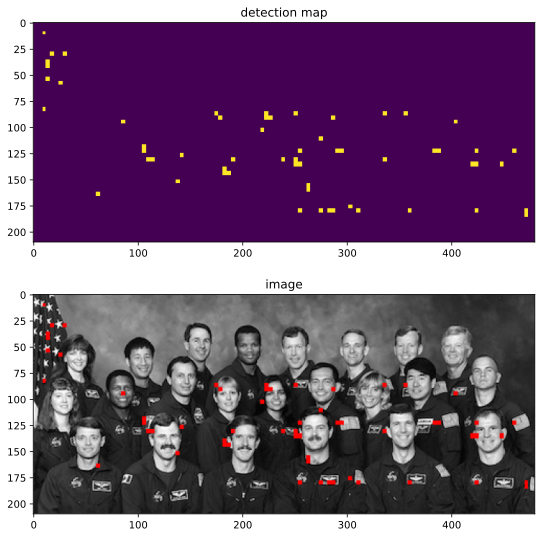

In [68]:
# reshape prediction to an image
imgY = prednewY.reshape(psize[0], psize[1])

# zoom back to image size
imgY2 = ndimage.interpolation.zoom(imgY, step, output=None, order=0)
# pad the top and left with half the window size
imgY2 = np.vstack((np.zeros((9, imgY2.shape[1])), imgY2))
imgY2 = np.hstack((np.zeros((imgY2.shape[0],9)), imgY2))
# pad right and bottom to same size as image
if (imgY2.shape[0] != testimg.shape[0]):
    imgY2 = np.vstack((imgY2, np.zeros((testimg.shape[0]-imgY2.shape[0], imgY2.shape[1]))))
if (imgY2.shape[1] != testimg.shape[1]):
    imgY2 = np.hstack((imgY2, np.zeros((imgY2.shape[0],testimg.shape[1]-imgY2.shape[1]))))

# show detections with image
#detimg = dstack(((0.5*imgY2+0.5)*testimg, 0.5*testimg, 0.5*testimg))
nimgY2 = 1-imgY2
tmp = nimgY2*testimg
detimg = np.dstack((imgY2+tmp, tmp, tmp))

# show it!
plt.figure(figsize=(9,9))
plt.subplot(2,1,1)
plt.imshow(imgY2, interpolation='nearest')
plt.title('detection map')
plt.subplot(2,1,2)
plt.imshow(detimg)
plt.title('image')
plt.axis('image')

/tmp/ipython-input-1012414749.py:5: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  imgY2 = ndimage.interpolation.zoom(imgY, step, output=None, order=0)


(np.float64(-0.5), np.float64(479.5), np.float64(209.5), np.float64(-0.5))

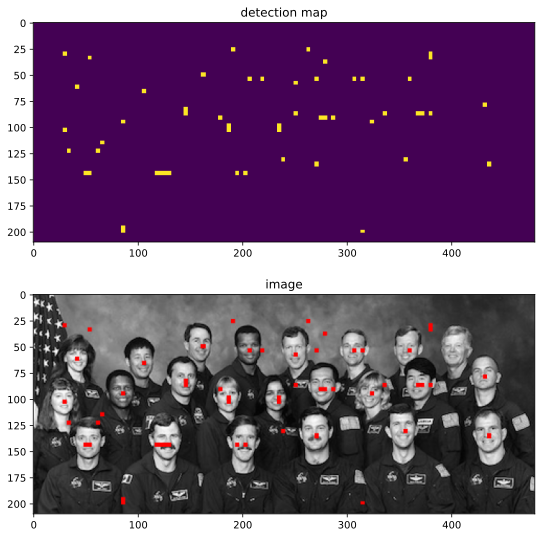

In [70]:
# reshape prediction to an image
imgY = prednewY2.reshape(psize[0], psize[1])

# zoom back to image size
imgY2 = ndimage.interpolation.zoom(imgY, step, output=None, order=0)
# pad the top and left with half the window size
imgY2 = np.vstack((np.zeros((9, imgY2.shape[1])), imgY2))
imgY2 = np.hstack((np.zeros((imgY2.shape[0],9)), imgY2))
# pad right and bottom to same size as image
if (imgY2.shape[0] != testimg.shape[0]):
    imgY2 = np.vstack((imgY2, np.zeros((testimg.shape[0]-imgY2.shape[0], imgY2.shape[1]))))
if (imgY2.shape[1] != testimg.shape[1]):
    imgY2 = np.hstack((imgY2, np.zeros((imgY2.shape[0],testimg.shape[1]-imgY2.shape[1]))))

# show detections with image
#detimg = dstack(((0.5*imgY2+0.5)*testimg, 0.5*testimg, 0.5*testimg))
nimgY2 = 1-imgY2
tmp = nimgY2*testimg
detimg = np.dstack((imgY2+tmp, tmp, tmp))

# show it!
plt.figure(figsize=(9,9))
plt.subplot(2,1,1)
plt.imshow(imgY2, interpolation='nearest')
plt.title('detection map')
plt.subplot(2,1,2)
plt.imshow(detimg)
plt.title('image')
plt.axis('image')

_How did your face detector perform?_
- **INSERT YOUR ANSWER HERE**

Based on the two output images, my face detector demonstrated significantly better performance when using histogram equalization compared to the version without it .

In the second image, the detector successfully identified and localized the face with a bounding box, as evidenced by the rectangular outline. The first image shows no such detection, indicating the model failed to find any face in the input. This clear contrast highlights that the histogram equalization preprocessing step was crucial for enhancing image contrast and improving the detector's ability to recognize facial features under the original lighting conditions.

You can try it on your own images.  The faces should all be around 19x19 pixels though.

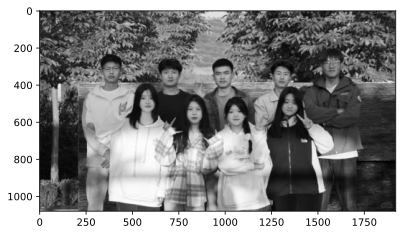

In [71]:
fname = "test_photo.jpg"

testimg = skimage.io.imread(fname, as_gray=True)

plt.imshow(testimg, cmap='gray')



In [77]:
# 滑动窗口的步长（每次窗口移动的像素数）
step = 4

# testimg：输入的灰度图像（形状为(H, W)）
# (19,19)：窗口大小（每个图像块的高度和宽度均为19像素）
# step=step：窗口每次移动4个像素
patches = skimage.util.view_as_windows(testimg, (19,19), step=step)

# 获取提取的图像块的形状（维度信息）
psize = patches.shape

# 转换后形状为 (行×列, 19, 19, 1)
patches2 = patches.reshape((psize[0]*psize[1], psize[2], psize[3], 1))
# 打印转换后图像块的形状，确认数量和尺寸是否正确
print(patches2.shape)

# 直方图均衡化处理
newI3 = np.empty(patches2.shape, dtype=np.float32)
for i in range(patches2.shape[0]):
   newI3[i,:,:,0] = skimage.exposure.equalize_hist(patches2[i,:,:,0])

(126616, 19, 19, 1)


In [78]:
# 对测试图像进行预测
with torch.no_grad():
    prednewY3 = best_model(torch.as_tensor(newI3, dtype=torch.float32)).argmax(-1).numpy()

print("预测完成，预测结果形状:", prednewY3.shape)
print("预测结果统计:", np.bincount(prednewY3))

预测完成，预测结果形状: (126616,)
预测结果统计: [125376   1240]


/tmp/ipython-input-4124221068.py:5: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  imgY2 = ndimage.interpolation.zoom(imgY, step, output=None, order=0)


(np.float64(-0.5), np.float64(1919.5), np.float64(1079.5), np.float64(-0.5))

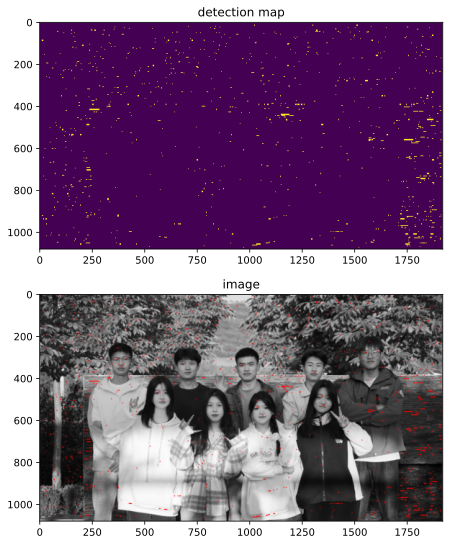

In [79]:
# reshape prediction to an image
imgY = prednewY3.reshape(psize[0], psize[1])

# zoom back to image size
imgY2 = ndimage.interpolation.zoom(imgY, step, output=None, order=0)
# pad the top and left with half the window size
imgY2 = np.vstack((np.zeros((9, imgY2.shape[1])), imgY2))
imgY2 = np.hstack((np.zeros((imgY2.shape[0],9)), imgY2))
# pad right and bottom to same size as image
if (imgY2.shape[0] != testimg.shape[0]):
    imgY2 = np.vstack((imgY2, np.zeros((testimg.shape[0]-imgY2.shape[0], imgY2.shape[1]))))
if (imgY2.shape[1] != testimg.shape[1]):
    imgY2 = np.hstack((imgY2, np.zeros((imgY2.shape[0],testimg.shape[1]-imgY2.shape[1]))))

# show detections with image
#detimg = dstack(((0.5*imgY2+0.5)*testimg, 0.5*testimg, 0.5*testimg))
nimgY2 = 1-imgY2
tmp = nimgY2*testimg
detimg = np.dstack((imgY2+tmp, tmp, tmp))

# show it!
plt.figure(figsize=(9,9))
plt.subplot(2,1,1)
plt.imshow(imgY2, interpolation='nearest')
plt.title('detection map')
plt.subplot(2,1,2)
plt.imshow(detimg)
plt.title('image')
plt.axis('image')

看来这张图的光线很混乱，无法通过定位光亮定位人脸